# Klasifikasi Buah: Analisis Pengaruh Edge Features

## Tujuan
Menguji apakah **edge detection features** meningkatkan akurasi klasifikasi buah dibandingkan dengan hanya menggunakan **color features**.

## Dataset
- **Fruit-262** (subset 20 kelas)
- Kelas: apple, avocado, banana, bell pepper, blueberry, cherry, coconut, dragonfruit, eggplant, grape, kiwi, lemon, lime, mango, orange, papaya, pear, pineapple, strawberry, watermelon

## Eksperimen
1. **Random Forest - Color Only**: Hanya color histogram (512 features)
2. **Random Forest - Color + Edge**: Color histogram + edge statistics (531 features)
3. **Perbandingan**: Analisis apakah edge features membantu atau tidak

## 1. Import Libraries

In [26]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path('../src').resolve()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Import custom modules
from preprocessing import extract_combined_features, extract_color_only_features
from ml_models import (
    load_images_and_extract_features,
    train_random_forest,
    evaluate_ml_model,
    save_ml_model,
    load_ml_model
)
from evaluation import (
    plot_confusion_matrix,
    print_classification_report,
    compare_models
)
from utils import (
    get_class_names,
    count_images_per_class
)

print(f"Setup complete!")

Setup complete!


## 2. Setup Paths dan Konfigurasi

In [27]:
# Directories
BASE_DIR = Path('..').resolve()
DATA_DIR = BASE_DIR / 'data'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

# Hyperparameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 20

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"Base directory: {BASE_DIR}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"\nImage size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Base directory: D:\dev\semester5\pengolahan-citra\projek-edge-detection
Train directory: D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\train
Test directory: D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\test

Image size: (128, 128)
Batch size: 32
Epochs: 20


## 3. Eksplorasi Data

Cek apakah dataset sudah siap. Jika belum, jalankan script `data_preparation.py` terlebih dahulu.

In [28]:
# Check if data directories exist
if not TRAIN_DIR.exists() or not TEST_DIR.exists():
    print("Data directories not found!")
    print("Please run: python src/data_preparation.py")
else:
    # Get class names
    class_names = get_class_names(TRAIN_DIR)
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}\n")
    
    # Count images per class
    train_counts = count_images_per_class(TRAIN_DIR)
    test_counts = count_images_per_class(TEST_DIR)
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'Class': list(train_counts.keys()),
        'Train Images': list(train_counts.values()),
        'Test Images': list(test_counts.values())
    })
    summary_df['Total'] = summary_df['Train Images'] + summary_df['Test Images']
    
    print("Dataset Summary:")
    print(summary_df.to_string(index=False))
    print(f"\nTotal train images: {sum(train_counts.values())}")
    print(f"Total test images: {sum(test_counts.values())}")

Number of classes: 20
Classes: ['apple', 'avocado', 'banana', 'bell pepper', 'blueberry', 'cherry', 'coconut', 'dragonfruit', 'eggplant', 'grape', 'kiwi', 'lemon', 'lime', 'mango', 'orange', 'papaya', 'pear', 'pineapple', 'strawberry', 'watermelon']

Dataset Summary:
      Class  Train Images  Test Images  Total
      apple           962          241   1203
    avocado           935          234   1169
     banana           929          233   1162
bell pepper           800          200   1000
  blueberry           801          201   1002
     cherry           802          201   1003
    coconut           819          205   1024
dragonfruit           828          207   1035
   eggplant           809          203   1012
      grape           826          207   1033
       kiwi           808          202   1010
      lemon           808          203   1011
       lime           808          202   1010
      mango           820          205   1025
     orange           656          165    

## 4. Feature Extraction: Visualisasi

Lihat fitur apa saja yang di-extract dari setiap gambar.

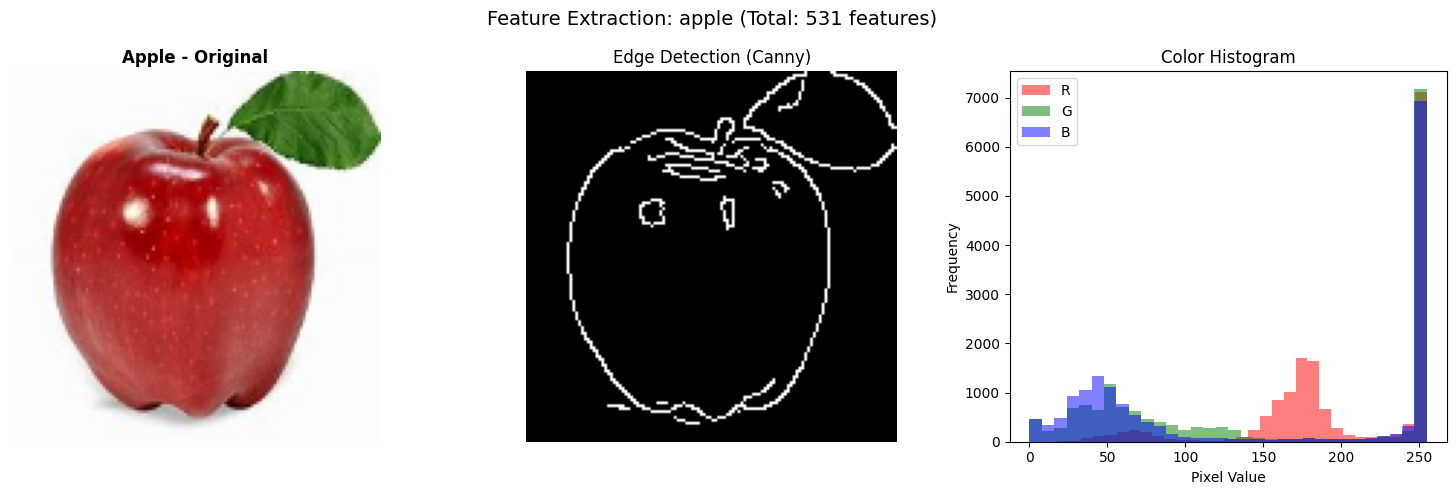

apple: 531 features extracted
  - Color histogram: 512 features (8x8x8 bins)
  - Edge statistics: 19 features



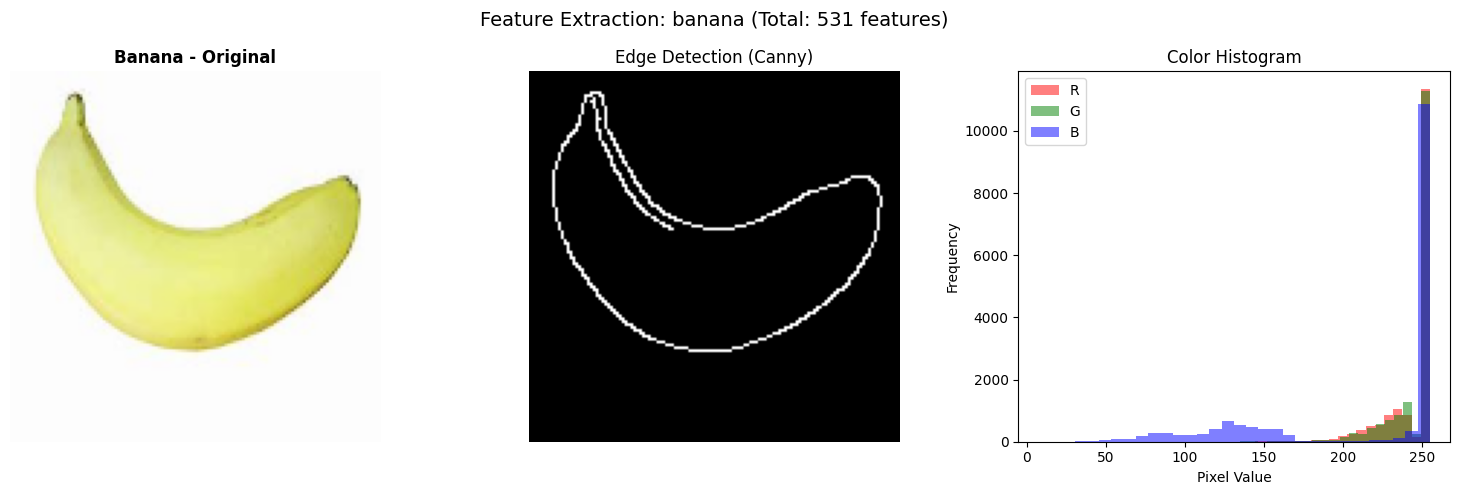

banana: 531 features extracted
  - Color histogram: 512 features (8x8x8 bins)
  - Edge statistics: 19 features



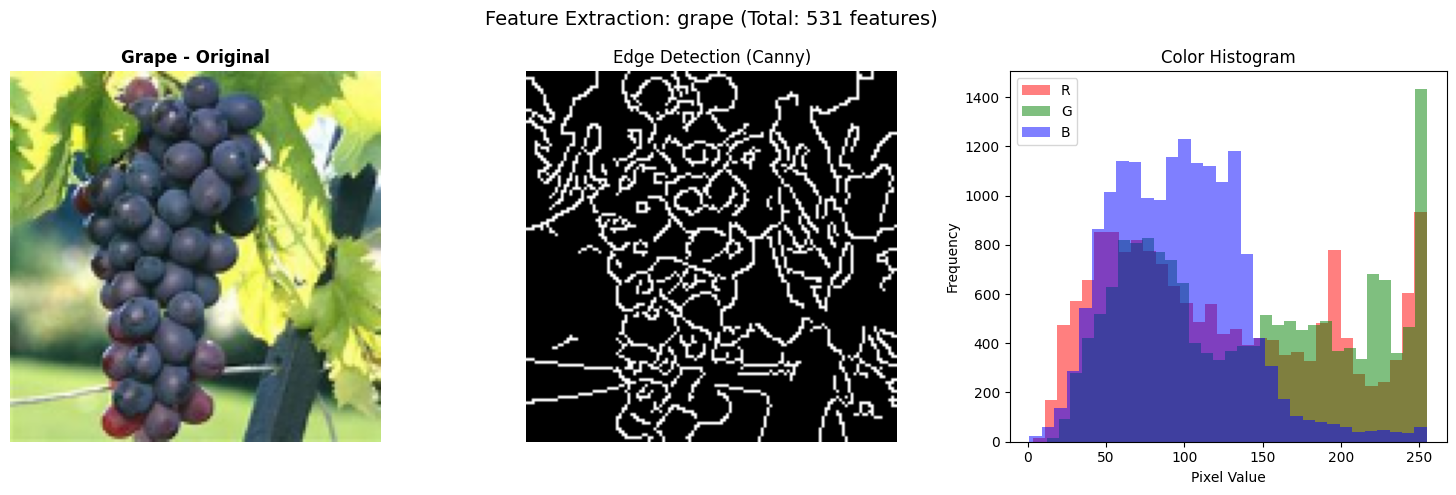

grape: 531 features extracted
  - Color histogram: 512 features (8x8x8 bins)
  - Edge statistics: 19 features



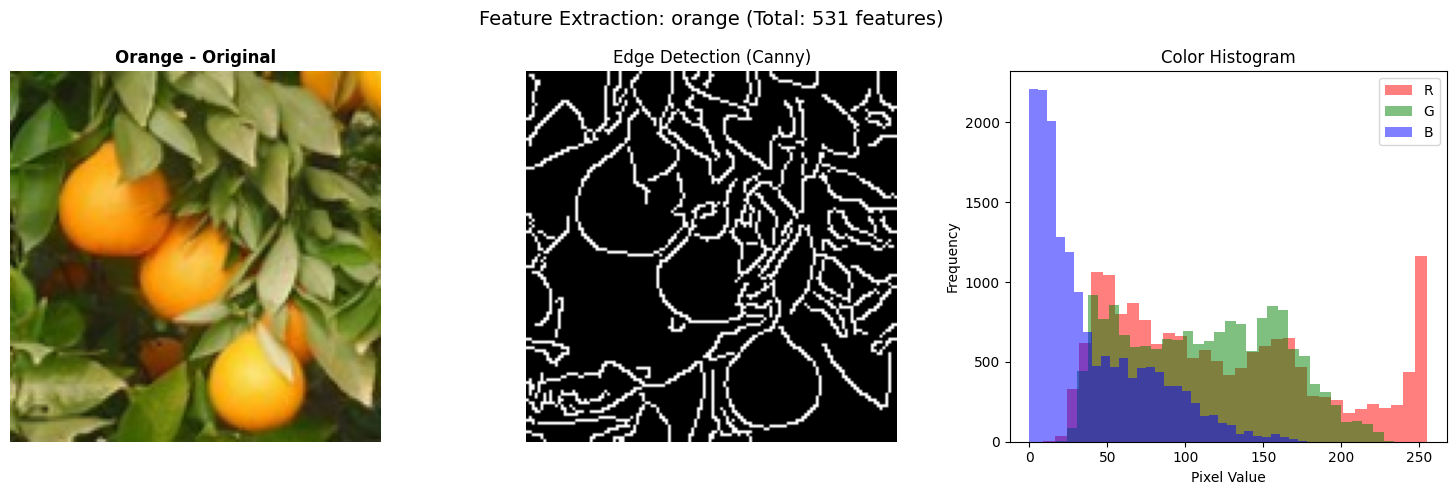

orange: 531 features extracted
  - Color histogram: 512 features (8x8x8 bins)
  - Edge statistics: 19 features



In [29]:
# Visualize feature extraction
sample_classes = ['apple', 'banana', 'grape', 'orange']

for cls_name in sample_classes:
    cls_dir = TRAIN_DIR / cls_name
    if cls_dir.exists():
        img_files = list(cls_dir.glob('*'))
        if img_files:
            img_path = img_files[0]
            
            # Load and resize
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
            
            # Extract features
            features = extract_combined_features(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
            
            # Apply edge detection for visualization
            from preprocessing import apply_canny_edge_detection
            edges = apply_canny_edge_detection(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
            
            # Visualize
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(img_resized)
            axes[0].set_title(f'{cls_name.capitalize()} - Original', fontsize=12, fontweight='bold')
            axes[0].axis('off')
            
            axes[1].imshow(edges, cmap='gray')
            axes[1].set_title('Edge Detection (Canny)', fontsize=12)
            axes[1].axis('off')
            
            # Plot color histogram
            axes[2].hist(img_resized[:,:,0].ravel(), bins=32, color='red', alpha=0.5, label='R')
            axes[2].hist(img_resized[:,:,1].ravel(), bins=32, color='green', alpha=0.5, label='G')
            axes[2].hist(img_resized[:,:,2].ravel(), bins=32, color='blue', alpha=0.5, label='B')
            axes[2].set_title('Color Histogram', fontsize=12)
            axes[2].set_xlabel('Pixel Value')
            axes[2].set_ylabel('Frequency')
            axes[2].legend()
            
            plt.suptitle(f'Feature Extraction: {cls_name} (Total: {len(features)} features)', fontsize=14)
            plt.tight_layout()
            plt.show()
            
            print(f"{cls_name}: {len(features)} features extracted")
            print(f"  - Color histogram: 512 features (8x8x8 bins)")
            print(f"  - Edge statistics: {len(features) - 512} features\n")

## 5. Eksperimen 1: Random Forest - Color Only (No Edge Features)

In [30]:
print("="*60)
print("RANDOM FOREST - COLOR FEATURES ONLY")
print("="*60)

print("\nFeatures yang di-extract:")
print("  - Color Histogram (8x8x8 bins) = 512 features")
print("  - NO edge features")
print("  - Total: 512 features per image")

RANDOM FOREST - COLOR FEATURES ONLY

Features yang di-extract:
  - Color Histogram (8x8x8 bins) = 512 features
  - NO edge features
  - Total: 512 features per image


In [31]:
# Load and extract COLOR ONLY features from training data
X_train_color, y_train_color, class_names = load_images_and_extract_features(
    TRAIN_DIR,
    feature_extractor=extract_color_only_features,
    image_size=IMAGE_SIZE
)

print(f"\nTraining set (Color Only):")
print(f"  Samples: {len(X_train_color)}")
print(f"  Features: {X_train_color.shape[1]}")
print(f"  Classes: {len(class_names)}")

Loading images and extracting features from D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\train...


Processing classes: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]

Loaded 16463 samples, Feature dimension: 512

Training set (Color Only):
  Samples: 16463
  Features: 512
  Classes: 20


In [32]:
# Load and extract COLOR ONLY features from test data
X_test_color, y_test_color, _ = load_images_and_extract_features(
    TEST_DIR,
    feature_extractor=extract_color_only_features,
    image_size=IMAGE_SIZE
)

print(f"\nTest set (Color Only):")
print(f"  Samples: {len(X_test_color)}")
print(f"  Features: {X_test_color.shape[1]}")

Loading images and extracting features from D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\test...


Processing classes: 100%|██████████| 20/20 [00:01<00:00, 12.10it/s]


Loaded 4126 samples, Feature dimension: 512

Test set (Color Only):
  Samples: 4126
  Features: 512


In [33]:
# Train Random Forest (Color Only)
model_rf_color, scaler_rf_color = train_random_forest(
    X_train_color, 
    y_train_color, 
    n_estimators=200,
    random_state=RANDOM_SEED
)

# Save model
save_ml_model(model_rf_color, scaler_rf_color, RESULTS_DIR / 'model_rf_color_only.pkl')
print("\nModel saved!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.



Training Random Forest with 200 trees...


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.3s


Training complete!
Model saved to D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\model_rf_color_only.pkl

Model saved!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished



CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple     0.6346    0.4108    0.4987       241
     avocado     0.4984    0.6538    0.5656       234
      banana     0.6137    0.6137    0.6137       233
 bell pepper     0.8440    0.5950    0.6979       200
   blueberry     0.7114    0.8706    0.7830       201
      cherry     0.7730    0.7114    0.7409       201
     coconut     0.6263    0.6049    0.6154       205
 dragonfruit     0.7883    0.8454    0.8159       207
    eggplant     0.7265    0.8374    0.7780       203
       grape     0.6644    0.4783    0.5562       207
        kiwi     0.6352    0.7327    0.6805       202
       lemon     0.6208    0.7340    0.6727       203
        lime     0.5270    0.6287    0.5734       202
       mango     0.6349    0.3902    0.4834       205
      orange     0.7577    0.8909    0.8189       165
      papaya     0.6717    0.6456    0.6584       206
        pear     0.5316    0.4158    0.4667       202
   p

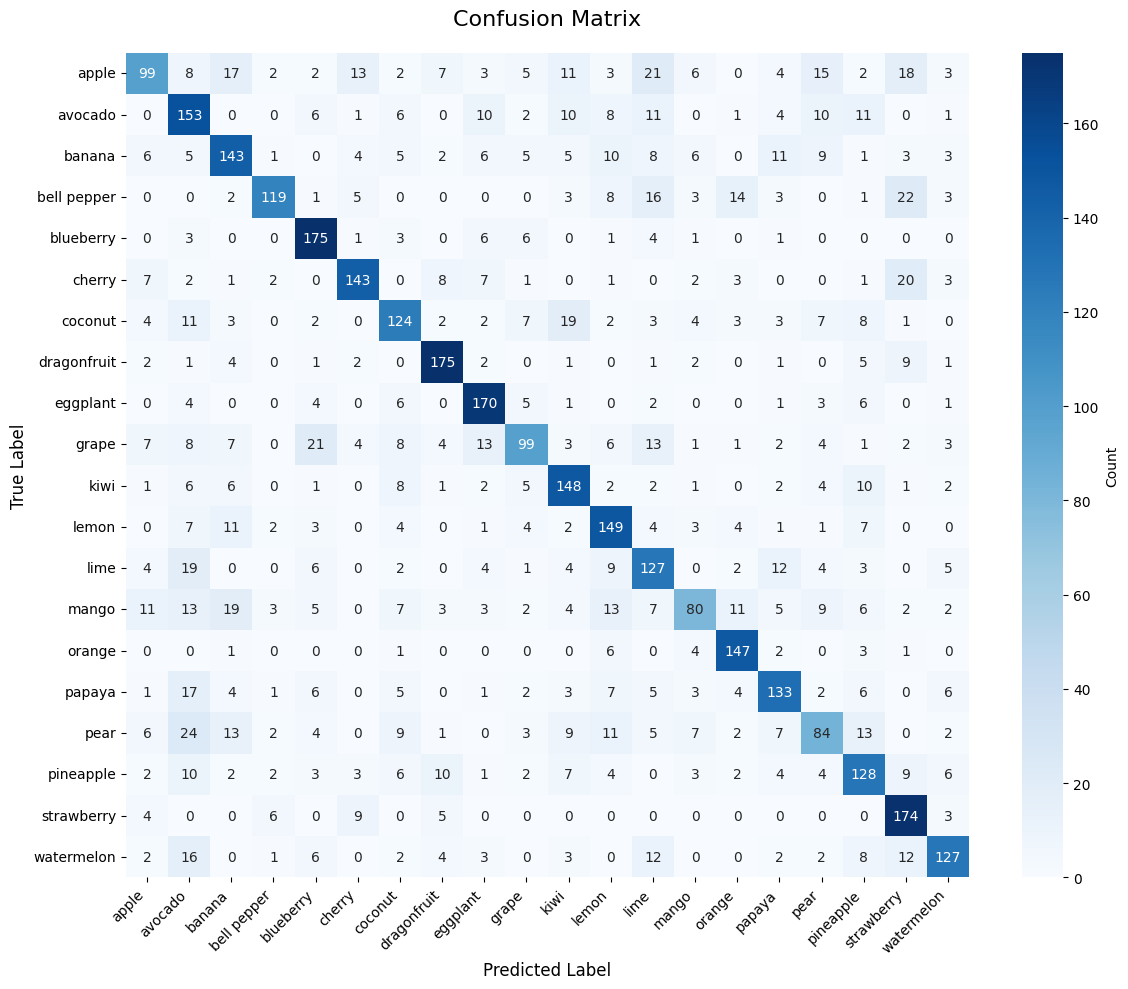


Classification Report:
              precision    recall  f1-score   support

       apple     0.6346    0.4108    0.4987       241
     avocado     0.4984    0.6538    0.5656       234
      banana     0.6137    0.6137    0.6137       233
 bell pepper     0.8440    0.5950    0.6979       200
   blueberry     0.7114    0.8706    0.7830       201
      cherry     0.7730    0.7114    0.7409       201
     coconut     0.6263    0.6049    0.6154       205
 dragonfruit     0.7883    0.8454    0.8159       207
    eggplant     0.7265    0.8374    0.7780       203
       grape     0.6644    0.4783    0.5562       207
        kiwi     0.6352    0.7327    0.6805       202
       lemon     0.6208    0.7340    0.6727       203
        lime     0.5270    0.6287    0.5734       202
       mango     0.6349    0.3902    0.4834       205
      orange     0.7577    0.8909    0.8189       165
      papaya     0.6717    0.6456    0.6584       206
        pear     0.5316    0.4158    0.4667       202
   

'              precision    recall  f1-score   support\n\n       apple     0.6346    0.4108    0.4987       241\n     avocado     0.4984    0.6538    0.5656       234\n      banana     0.6137    0.6137    0.6137       233\n bell pepper     0.8440    0.5950    0.6979       200\n   blueberry     0.7114    0.8706    0.7830       201\n      cherry     0.7730    0.7114    0.7409       201\n     coconut     0.6263    0.6049    0.6154       205\n dragonfruit     0.7883    0.8454    0.8159       207\n    eggplant     0.7265    0.8374    0.7780       203\n       grape     0.6644    0.4783    0.5562       207\n        kiwi     0.6352    0.7327    0.6805       202\n       lemon     0.6208    0.7340    0.6727       203\n        lime     0.5270    0.6287    0.5734       202\n       mango     0.6349    0.3902    0.4834       205\n      orange     0.7577    0.8909    0.8189       165\n      papaya     0.6717    0.6456    0.6584       206\n        pear     0.5316    0.4158    0.4667       202\n   pine

In [34]:
# Evaluate Random Forest (Color Only)
metrics_rf_color = evaluate_ml_model(
    model_rf_color, 
    scaler_rf_color, 
    X_test_color, 
    y_test_color, 
    class_names
)

print(f"\nRandom Forest (Color Only) Results:")
print(f"  Accuracy:  {metrics_rf_color['accuracy']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    metrics_rf_color['y_true'], 
    metrics_rf_color['y_pred'],
    class_names=class_names,
    save_path=RESULTS_DIR / 'confusion_matrix' / 'rf_color_only.png'
)
plt.show()

# Print classification report
print_classification_report(
    metrics_rf_color['y_true'], 
    metrics_rf_color['y_pred'],
    class_names=class_names
)

## 6. Eksperimen 2: Random Forest - Color + Edge Features

In [35]:
print("="*60)
print("RANDOM FOREST - COLOR + EDGE FEATURES")
print("="*60)

print("\nFeatures yang di-extract:")
print("  - Color Histogram (8x8x8 bins) = 512 features")
print("  - Edge Statistics (density, mean, std) = 3 features")
print("  - Edge Histogram (16 bins) = 16 features")
print("  - Total: ~531 features per image")

RANDOM FOREST - COLOR + EDGE FEATURES

Features yang di-extract:
  - Color Histogram (8x8x8 bins) = 512 features
  - Edge Statistics (density, mean, std) = 3 features
  - Edge Histogram (16 bins) = 16 features
  - Total: ~531 features per image


In [36]:
# Load and extract COMBINED features from training data
X_train_combined, y_train_combined, _ = load_images_and_extract_features(
    TRAIN_DIR,
    feature_extractor=extract_combined_features,
    image_size=IMAGE_SIZE
)

print(f"\nTraining set (Color + Edge):")
print(f"  Samples: {len(X_train_combined)}")
print(f"  Features: {X_train_combined.shape[1]}")
print(f"  Classes: {len(class_names)}")

Loading images and extracting features from D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\train...


Processing classes: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

Loaded 16463 samples, Feature dimension: 531

Training set (Color + Edge):
  Samples: 16463
  Features: 531
  Classes: 20


In [37]:
# Load and extract COMBINED features from test data
X_test_combined, y_test_combined, _ = load_images_and_extract_features(
    TEST_DIR,
    feature_extractor=extract_combined_features,
    image_size=IMAGE_SIZE
)

print(f"\nTest set (Color + Edge):")
print(f"  Samples: {len(X_test_combined)}")
print(f"  Features: {X_test_combined.shape[1]}")

Loading images and extracting features from D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\test...


Processing classes: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]

Loaded 4126 samples, Feature dimension: 531

Test set (Color + Edge):
  Samples: 4126
  Features: 531


In [38]:
# Train Random Forest (Color + Edge)
model_rf_combined, scaler_rf_combined = train_random_forest(
    X_train_combined, 
    y_train_combined, 
    n_estimators=200,
    random_state=RANDOM_SEED
)

# Save model
save_ml_model(model_rf_combined, scaler_rf_combined, RESULTS_DIR / 'model_rf_combined.pkl')
print("\nModel saved!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.



Training Random Forest with 200 trees...


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.4s


Training complete!
Model saved to D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\model_rf_combined.pkl

Model saved!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished



CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple     0.6357    0.3693    0.4672       241
     avocado     0.4860    0.6667    0.5622       234
      banana     0.6058    0.6266    0.6160       233
 bell pepper     0.8425    0.6150    0.7110       200
   blueberry     0.7328    0.9005    0.8080       201
      cherry     0.7772    0.7463    0.7614       201
     coconut     0.6195    0.6195    0.6195       205
 dragonfruit     0.7936    0.8357    0.8141       207
    eggplant     0.7167    0.8227    0.7661       203
       grape     0.6897    0.4831    0.5682       207
        kiwi     0.6327    0.7079    0.6682       202
       lemon     0.6074    0.7241    0.6607       203
        lime     0.5333    0.6337    0.5792       202
       mango     0.6304    0.4244    0.5073       205
      orange     0.7619    0.8727    0.8136       165
      papaya     0.6812    0.6845    0.6828       206
        pear     0.5865    0.3861    0.4657       202
   p

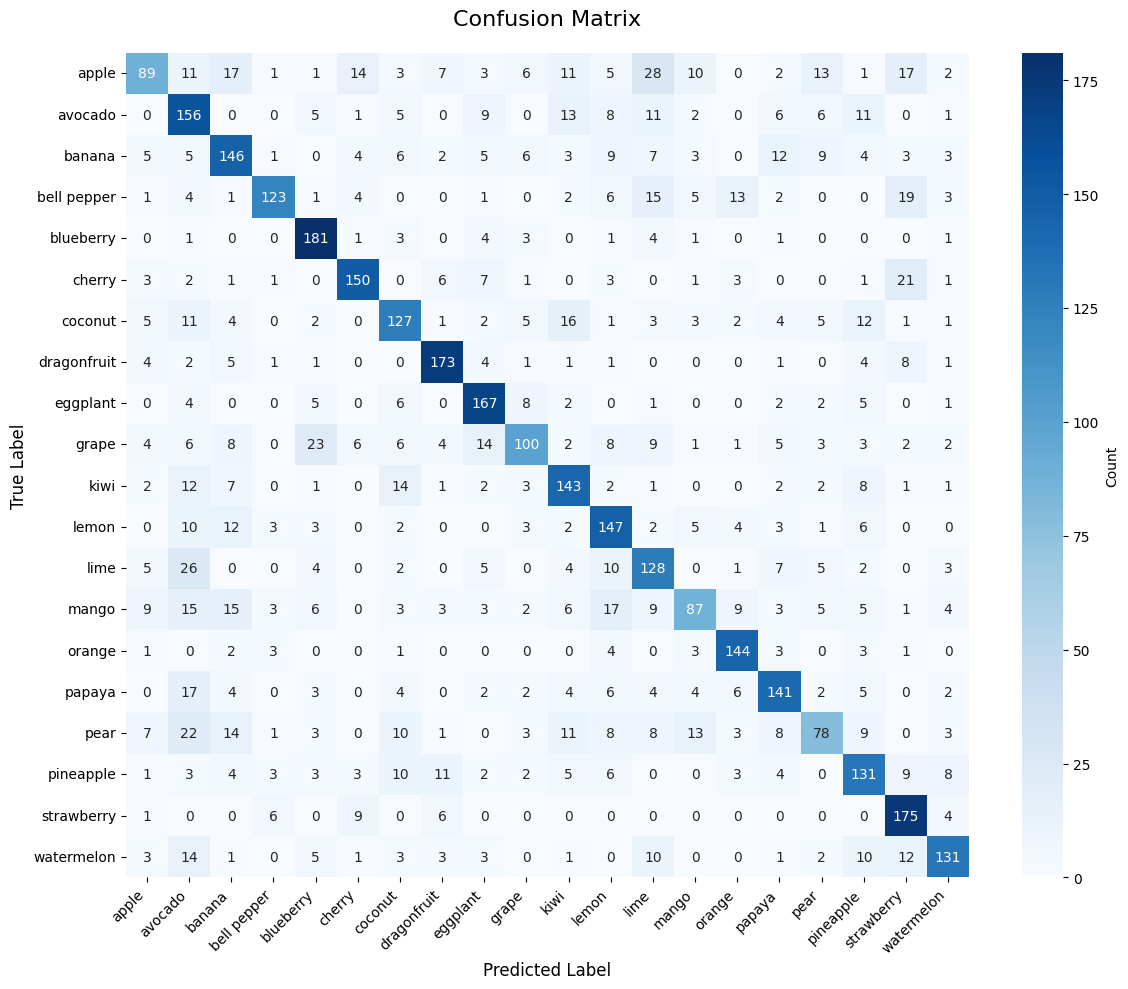


Classification Report:
              precision    recall  f1-score   support

       apple     0.6357    0.3693    0.4672       241
     avocado     0.4860    0.6667    0.5622       234
      banana     0.6058    0.6266    0.6160       233
 bell pepper     0.8425    0.6150    0.7110       200
   blueberry     0.7328    0.9005    0.8080       201
      cherry     0.7772    0.7463    0.7614       201
     coconut     0.6195    0.6195    0.6195       205
 dragonfruit     0.7936    0.8357    0.8141       207
    eggplant     0.7167    0.8227    0.7661       203
       grape     0.6897    0.4831    0.5682       207
        kiwi     0.6327    0.7079    0.6682       202
       lemon     0.6074    0.7241    0.6607       203
        lime     0.5333    0.6337    0.5792       202
       mango     0.6304    0.4244    0.5073       205
      orange     0.7619    0.8727    0.8136       165
      papaya     0.6812    0.6845    0.6828       206
        pear     0.5865    0.3861    0.4657       202
   

'              precision    recall  f1-score   support\n\n       apple     0.6357    0.3693    0.4672       241\n     avocado     0.4860    0.6667    0.5622       234\n      banana     0.6058    0.6266    0.6160       233\n bell pepper     0.8425    0.6150    0.7110       200\n   blueberry     0.7328    0.9005    0.8080       201\n      cherry     0.7772    0.7463    0.7614       201\n     coconut     0.6195    0.6195    0.6195       205\n dragonfruit     0.7936    0.8357    0.8141       207\n    eggplant     0.7167    0.8227    0.7661       203\n       grape     0.6897    0.4831    0.5682       207\n        kiwi     0.6327    0.7079    0.6682       202\n       lemon     0.6074    0.7241    0.6607       203\n        lime     0.5333    0.6337    0.5792       202\n       mango     0.6304    0.4244    0.5073       205\n      orange     0.7619    0.8727    0.8136       165\n      papaya     0.6812    0.6845    0.6828       206\n        pear     0.5865    0.3861    0.4657       202\n   pine

In [39]:
# Evaluate Random Forest (Color + Edge)
metrics_rf_combined = evaluate_ml_model(
    model_rf_combined, 
    scaler_rf_combined, 
    X_test_combined, 
    y_test_combined, 
    class_names
)

print(f"\nRandom Forest (Color + Edge) Results:")
print(f"  Accuracy:  {metrics_rf_combined['accuracy']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    metrics_rf_combined['y_true'], 
    metrics_rf_combined['y_pred'],
    class_names=class_names,
    save_path=RESULTS_DIR / 'confusion_matrix' / 'rf_combined.png'
)
plt.show()

# Print classification report
print_classification_report(
    metrics_rf_combined['y_true'], 
    metrics_rf_combined['y_pred'],
    class_names=class_names
)

## 7. Perbandingan: Color Only vs Color + Edge Features

In [40]:
# Compile results
results_comparison = {
    'RF - Color Only (512 features)': {
        'accuracy': metrics_rf_color['accuracy'],
        'precision': metrics_rf_color['accuracy'],
        'recall': metrics_rf_color['accuracy'],
        'f1_score': metrics_rf_color['accuracy']
    },
    'RF - Color + Edge (531 features)': {
        'accuracy': metrics_rf_combined['accuracy'],
        'precision': metrics_rf_combined['accuracy'],
        'recall': metrics_rf_combined['accuracy'],
        'f1_score': metrics_rf_combined['accuracy']
    }
}

# Create comparison dataframe
comparison_df = pd.DataFrame(results_comparison).T
comparison_df = comparison_df.round(4)

print("\n" + "="*70)
print("COMPARISON: Does Edge Detection Help?")
print("="*70)
print(comparison_df)

# Calculate improvement
color_acc = metrics_rf_color['accuracy']
combined_acc = metrics_rf_combined['accuracy']
improvement = combined_acc - color_acc
improvement_pct = (improvement / color_acc) * 100

print(f"\nAccuracy Improvement with Edge Features:")
print(f"  Color Only: {color_acc:.4f} ({color_acc*100:.2f}%)")
print(f"  Color + Edge: {combined_acc:.4f} ({combined_acc*100:.2f}%)")
print(f"  Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)")

if improvement > 0:
    print("\nConclusion: Edge features HELP classification!")
elif improvement < -0.01:
    print("\nConclusion: Edge features HURT classification!")
else:
    print("\nConclusion: Edge features have MINIMAL impact!")

# Save comparison table
comparison_df.to_csv(RESULTS_DIR / 'edge_features_comparison.csv')
print(f"\nComparison saved to {RESULTS_DIR / 'edge_features_comparison.csv'}")


COMPARISON: Does Edge Detection Help?
                                  accuracy  precision  recall  f1_score
RF - Color Only (512 features)      0.6537     0.6537  0.6537    0.6537
RF - Color + Edge (531 features)    0.6585     0.6585  0.6585    0.6585

Accuracy Improvement with Edge Features:
  Color Only: 0.6537 (65.37%)
  Color + Edge: 0.6585 (65.85%)
  Improvement: +0.0048 (+0.74%)

Conclusion: Edge features HELP classification!

Comparison saved to D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\edge_features_comparison.csv


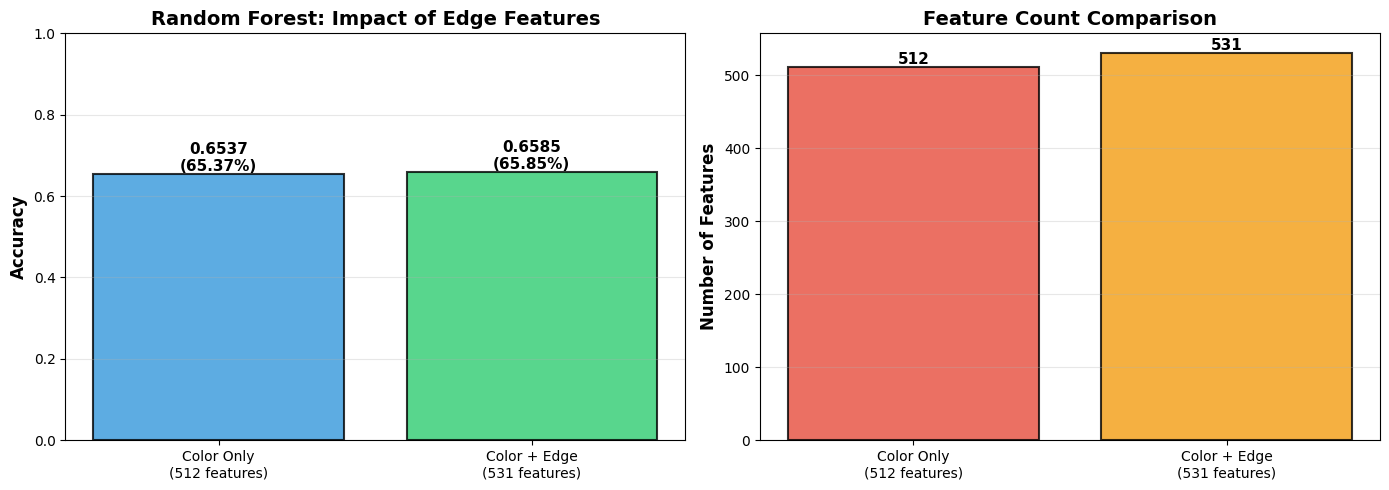

In [41]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
models = ['Color Only\n(512 features)', 'Color + Edge\n(531 features)']
accuracies = [metrics_rf_color['accuracy'], metrics_rf_combined['accuracy']]
colors = ['#3498db', '#2ecc71']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Random Forest: Impact of Edge Features', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}\n({height*100:.2f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Feature count comparison
feature_counts = [512, 531]
axes[1].bar(models, feature_counts, color=['#e74c3c', '#f39c12'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Features', fontsize=12, fontweight='bold')
axes[1].set_title('Feature Count Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (model, count) in enumerate(zip(models, feature_counts)):
    axes[1].text(i, count, f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'edge_features_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Kesimpulan

In [42]:
print("="*70)
print("FINAL REPORT")
print("="*70)

print("\n1. RESEARCH QUESTION:")
print("   Apakah edge detection features membantu klasifikasi buah?")

print("\n2. PENDEKATAN:")
print("   - Eksperimen 1: Random Forest dengan Color Histogram saja (512 features)")
print("   - Eksperimen 2: Random Forest dengan Color + Edge Statistics (531 features)")

print("\n3. HASIL:")
print(comparison_df)

print("\n4. ANSWER:")
color_acc = metrics_rf_color['accuracy']
combined_acc = metrics_rf_combined['accuracy']
diff = combined_acc - color_acc

if diff > 0.01:  # More than 1% improvement
    print(f"   EDGE FEATURES HELP! (+{diff:.4f} or +{(diff/color_acc)*100:.2f}%)")
    print("\n   Interpretasi:")
    print("   - Edge statistics menambah informasi yang berguna")
    print("   - Shape/kontur buah membantu membedakan kelas")
    print("   - Kombinasi color + shape = lebih robust")
elif diff < -0.01:  # More than 1% degradation
    print(f"   EDGE FEATURES HURT! ({diff:.4f} or {(diff/color_acc)*100:.2f}%)")
    print("\n   Interpretasi:")
    print("   - Edge features menambah noise")
    print("   - Color information sudah cukup untuk klasifikasi buah")
    print("   - Extra features tidak relevan untuk task ini")
else:
    print(f"   EDGE FEATURES HAVE MINIMAL IMPACT ({diff:.4f})")
    print("\n   Interpretasi:")
    print("   - Edge features tidak menambah informasi signifikan")
    print("   - Color histogram sudah capture informasi penting")
    print("   - Kompleksitas tambahan tidak worth it")

print("\n5. REKOMENDASI:")
if diff > 0.01:
    print("   - Gunakan model dengan Color + Edge features")
    print("   - Edge detection terbukti meningkatkan performa")
    print(f"   - Model: {RESULTS_DIR / 'model_rf_combined.pkl'}")
else:
    print("   - Gunakan model dengan Color Only features")
    print("   - Lebih simple, features lebih sedikit")
    print("   - Performance sama atau lebih baik")
    print(f"   - Model: {RESULTS_DIR / 'model_rf_color_only.pkl'}")

print("\n6. FILES OUTPUT:")
print(f"   - RF Color Only: {RESULTS_DIR / 'model_rf_color_only.pkl'}")
print(f"   - RF Combined: {RESULTS_DIR / 'model_rf_combined.pkl'}")
print(f"   - Confusion matrices: {RESULTS_DIR / 'confusion_matrix/'}")
print(f"   - Comparison: {RESULTS_DIR / 'edge_features_comparison.csv'}")

print("\n" + "="*70)
print("EKSPERIMEN SELESAI")
print("="*70)

FINAL REPORT

1. RESEARCH QUESTION:
   Apakah edge detection features membantu klasifikasi buah?

2. PENDEKATAN:
   - Eksperimen 1: Random Forest dengan Color Histogram saja (512 features)
   - Eksperimen 2: Random Forest dengan Color + Edge Statistics (531 features)

3. HASIL:
                                  accuracy  precision  recall  f1_score
RF - Color Only (512 features)      0.6537     0.6537  0.6537    0.6537
RF - Color + Edge (531 features)    0.6585     0.6585  0.6585    0.6585

4. ANSWER:
   EDGE FEATURES HAVE MINIMAL IMPACT (0.0048)

   Interpretasi:
   - Edge features tidak menambah informasi signifikan
   - Color histogram sudah capture informasi penting
   - Kompleksitas tambahan tidak worth it

5. REKOMENDASI:
   - Gunakan model dengan Color Only features
   - Lebih simple, features lebih sedikit
   - Performance sama atau lebih baik
   - Model: D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\model_rf_color_only.pkl

6. FILES OUTPUT:
   - RF Color Only

## 9. Strategi Meningkatkan Dampak Edge Features

Dari hasil eksperimen, edge features hanya memberikan kenaikan 0.5%. Berikut strategi untuk meningkatkan dampaknya:

### A. Edge Feature Engineering yang Lebih Baik
1. **Multi-Scale Edge Detection**: Gunakan multiple thresholds Canny
2. **Oriented Gradients**: Histogram of Oriented Gradients (HOG)
3. **Edge Direction**: Capture arah edge (horizontal, vertical, diagonal)
4. **Contour Features**: Jumlah contour, area, perimeter, circularity

### B. Feature Selection & Weighting
1. **Feature Importance**: Analisis feature importance dari Random Forest
2. **Weighted Features**: Berikan bobot lebih tinggi pada edge features
3. **PCA**: Reduksi dimensi untuk fokus pada fitur penting

### C. Advanced Edge Detection Methods
1. **Gabor Filters**: Capture texture dan orientation
2. **LoG (Laplacian of Gaussian)**: Lebih robust ke noise
3. **Structured Edges**: Deep learning-based edge detection

Mari kita implementasikan beberapa strategi ini!

## 10. Eksperimen 3: Random Forest - Advanced Edge Features

Implementasi edge features yang lebih sophisticated:
- **Multi-scale edges**: 3 threshold levels
- **Edge orientation**: 8-bin histogram untuk arah edge
- **Gradient statistics**: Mean, std, max, percentiles
- **Contour features**: Area, perimeter, circularity, aspect ratio

In [43]:
print("="*60)
print("RANDOM FOREST - COLOR + ADVANCED EDGE FEATURES")
print("="*60)

# Import advanced feature extractor
from preprocessing import extract_advanced_combined_features

print("\nAdvanced Features yang di-extract:")
print("  - Color Histogram (8x8x8 bins) = 512 features")
print("  - Multi-scale Edge Density (3 scales) = 3 features")
print("  - Edge Orientation Histogram (8 bins) = 8 features")
print("  - Gradient Statistics (mean, std, max, p75, p90) = 5 features")
print("  - Contour Features (count, area, perimeter, circularity, aspect) = 5 features")
print("  - Total: ~533 features per image")

RANDOM FOREST - COLOR + ADVANCED EDGE FEATURES

Advanced Features yang di-extract:
  - Color Histogram (8x8x8 bins) = 512 features
  - Multi-scale Edge Density (3 scales) = 3 features
  - Edge Orientation Histogram (8 bins) = 8 features
  - Gradient Statistics (mean, std, max, p75, p90) = 5 features
  - Contour Features (count, area, perimeter, circularity, aspect) = 5 features
  - Total: ~533 features per image


In [44]:
# Load and extract ADVANCED features from training data
X_train_advanced, y_train_advanced, _ = load_images_and_extract_features(
    TRAIN_DIR,
    feature_extractor=extract_advanced_combined_features,
    image_size=IMAGE_SIZE
)

print(f"\nTraining set (Color + Advanced Edge):")
print(f"  Samples: {len(X_train_advanced)}")
print(f"  Features: {X_train_advanced.shape[1]}")
print(f"  Classes: {len(class_names)}")

Loading images and extracting features from D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\train...


Processing classes: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]

Loaded 16463 samples, Feature dimension: 533

Training set (Color + Advanced Edge):
  Samples: 16463
  Features: 533
  Classes: 20


In [45]:
# Load and extract ADVANCED features from test data
X_test_advanced, y_test_advanced, _ = load_images_and_extract_features(
    TEST_DIR,
    feature_extractor=extract_advanced_combined_features,
    image_size=IMAGE_SIZE
)

print(f"\nTest set (Color + Advanced Edge):")
print(f"  Samples: {len(X_test_advanced)}")
print(f"  Features: {X_test_advanced.shape[1]}")

Loading images and extracting features from D:\dev\semester5\pengolahan-citra\projek-edge-detection\data\test...


Processing classes: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]

Loaded 4126 samples, Feature dimension: 533

Test set (Color + Advanced Edge):
  Samples: 4126
  Features: 533


In [46]:
# Train Random Forest (Advanced)
model_rf_advanced, scaler_rf_advanced = train_random_forest(
    X_train_advanced, 
    y_train_advanced, 
    n_estimators=200,
    random_state=RANDOM_SEED
)

# Save model
save_ml_model(model_rf_advanced, scaler_rf_advanced, RESULTS_DIR / 'model_rf_advanced.pkl')
print("\nModel saved!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.



Training Random Forest with 200 trees...


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.6s


Training complete!
Model saved to D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\model_rf_advanced.pkl

Model saved!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.0s finished


FEATURE IMPORTANCE ANALYSIS

Feature Group Importance:
  Color Features (512): 0.8770 (87.70%)
  Edge Features (21): 0.1230 (12.30%)

Top 20 Most Important Features:
  1. Feature 513 (Edge): 0.008767
  2. Feature 512 (Edge): 0.008738
  3. Feature 527 (Edge): 0.008226
  4. Feature 526 (Edge): 0.007953
  5. Feature 514 (Edge): 0.007811
  6. Feature 65 (Color): 0.007709
  7. Feature 209 (Color): 0.007572
  8. Feature 281 (Color): 0.007379
  9. Feature 153 (Color): 0.007243
  10. Feature 511 (Color): 0.007181
  11. Feature 64 (Color): 0.007146
  12. Feature 80 (Color): 0.007125
  13. Feature 137 (Color): 0.006966
  14. Feature 480 (Color): 0.006754
  15. Feature 528 (Edge): 0.006645
  16. Feature 226 (Color): 0.006638
  17. Feature 523 (Edge): 0.006621
  18. Feature 217 (Color): 0.006441
  19. Feature 136 (Color): 0.006420
  20. Feature 354 (Color): 0.006414


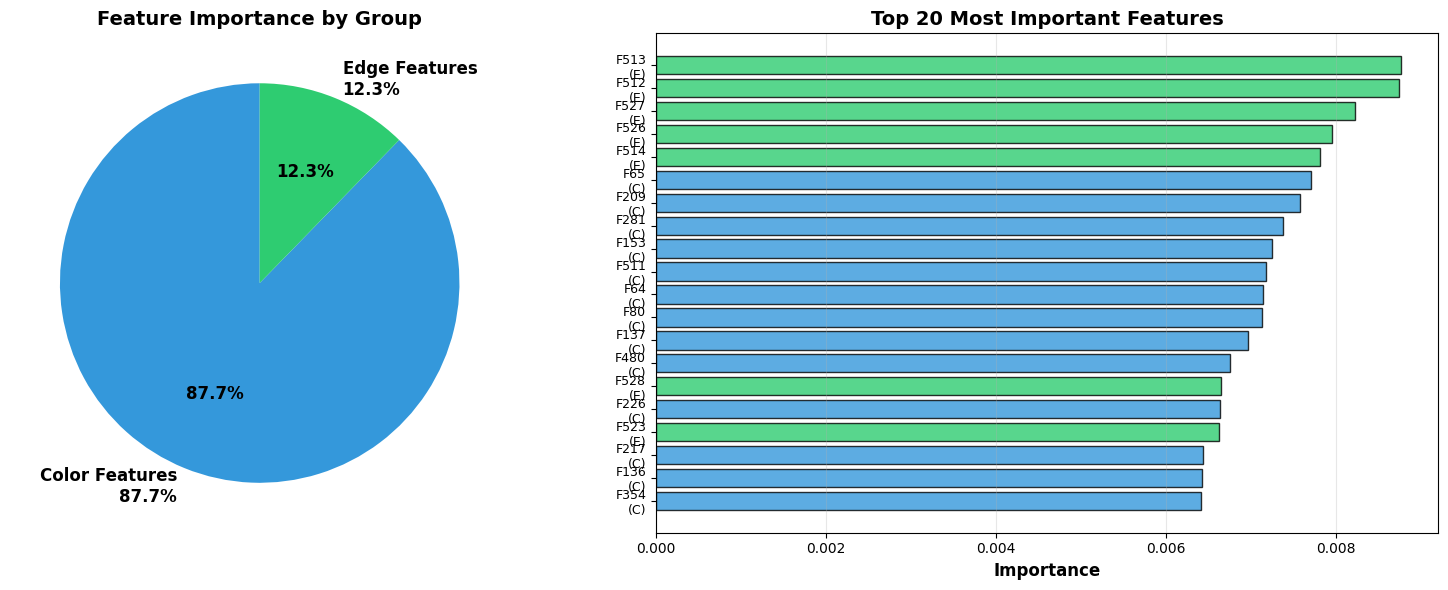

In [47]:
# Get feature importance from Advanced model
feature_importances = model_rf_advanced.feature_importances_

# Total features
n_color_features = 512
n_edge_features = X_train_advanced.shape[1] - n_color_features

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Calculate importance by feature group
color_importance = np.sum(feature_importances[:n_color_features])
edge_importance = np.sum(feature_importances[n_color_features:])

print(f"\nFeature Group Importance:")
print(f"  Color Features (512): {color_importance:.4f} ({color_importance*100:.2f}%)")
print(f"  Edge Features ({n_edge_features}): {edge_importance:.4f} ({edge_importance*100:.2f}%)")

# Get top 20 most important features
top_indices = np.argsort(feature_importances)[-20:][::-1]
top_importances = feature_importances[top_indices]

print(f"\nTop 20 Most Important Features:")
for i, (idx, importance) in enumerate(zip(top_indices, top_importances), 1):
    if idx < n_color_features:
        feature_type = "Color"
    else:
        feature_type = "Edge"
    print(f"  {i}. Feature {idx} ({feature_type}): {importance:.6f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Group importance pie chart
axes[0].pie([color_importance, edge_importance], 
           labels=[f'Color Features\n{color_importance*100:.1f}%', 
                  f'Edge Features\n{edge_importance*100:.1f}%'],
           colors=['#3498db', '#2ecc71'],
           autopct='%1.1f%%',
           startangle=90,
           textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Feature Importance by Group', fontsize=14, fontweight='bold')

# Top 20 features bar chart
feature_labels = [f"F{idx}\n({'C' if idx < n_color_features else 'E'})" 
                 for idx in top_indices]
axes[1].barh(range(20), top_importances, 
            color=['#3498db' if idx < n_color_features else '#2ecc71' for idx in top_indices],
            alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(feature_labels, fontsize=9)
axes[1].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished



CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple     0.5960    0.3734    0.4592       241
     avocado     0.5258    0.6966    0.5993       234
      banana     0.6320    0.6266    0.6293       233
 bell pepper     0.8278    0.6250    0.7123       200
   blueberry     0.7240    0.9005    0.8027       201
      cherry     0.7947    0.7512    0.7724       201
     coconut     0.6429    0.6146    0.6284       205
 dragonfruit     0.7621    0.8357    0.7972       207
    eggplant     0.7401    0.8276    0.7814       203
       grape     0.7174    0.4783    0.5739       207
        kiwi     0.6516    0.7129    0.6809       202
       lemon     0.5992    0.7291    0.6578       203
        lime     0.5294    0.6238    0.5727       202
       mango     0.5986    0.4293    0.5000       205
      orange     0.7660    0.8727    0.8159       165
      papaya     0.7245    0.6893    0.7065       206
        pear     0.5594    0.3960    0.4638       202
   p

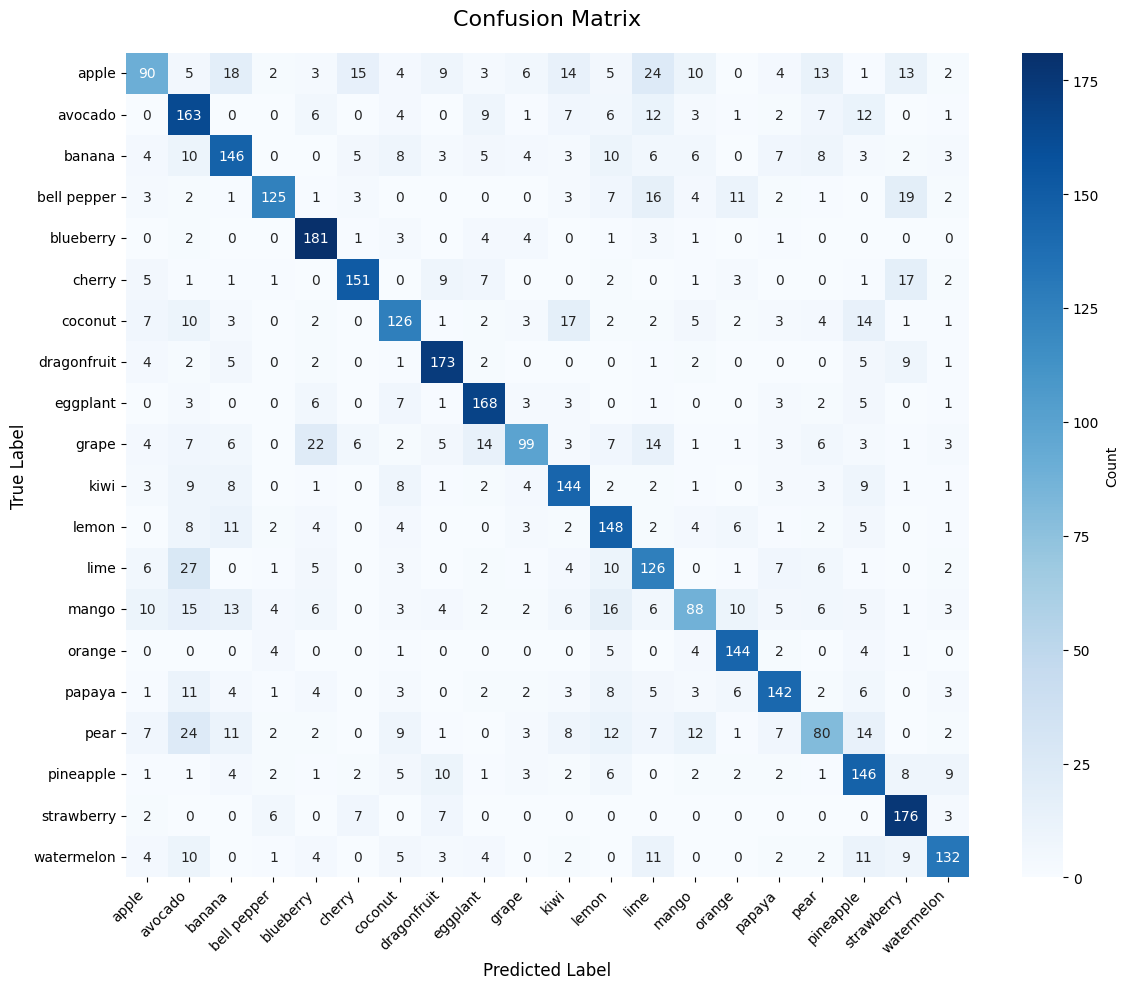


Classification Report:
              precision    recall  f1-score   support

       apple     0.5960    0.3734    0.4592       241
     avocado     0.5258    0.6966    0.5993       234
      banana     0.6320    0.6266    0.6293       233
 bell pepper     0.8278    0.6250    0.7123       200
   blueberry     0.7240    0.9005    0.8027       201
      cherry     0.7947    0.7512    0.7724       201
     coconut     0.6429    0.6146    0.6284       205
 dragonfruit     0.7621    0.8357    0.7972       207
    eggplant     0.7401    0.8276    0.7814       203
       grape     0.7174    0.4783    0.5739       207
        kiwi     0.6516    0.7129    0.6809       202
       lemon     0.5992    0.7291    0.6578       203
        lime     0.5294    0.6238    0.5727       202
       mango     0.5986    0.4293    0.5000       205
      orange     0.7660    0.8727    0.8159       165
      papaya     0.7245    0.6893    0.7065       206
        pear     0.5594    0.3960    0.4638       202
   

'              precision    recall  f1-score   support\n\n       apple     0.5960    0.3734    0.4592       241\n     avocado     0.5258    0.6966    0.5993       234\n      banana     0.6320    0.6266    0.6293       233\n bell pepper     0.8278    0.6250    0.7123       200\n   blueberry     0.7240    0.9005    0.8027       201\n      cherry     0.7947    0.7512    0.7724       201\n     coconut     0.6429    0.6146    0.6284       205\n dragonfruit     0.7621    0.8357    0.7972       207\n    eggplant     0.7401    0.8276    0.7814       203\n       grape     0.7174    0.4783    0.5739       207\n        kiwi     0.6516    0.7129    0.6809       202\n       lemon     0.5992    0.7291    0.6578       203\n        lime     0.5294    0.6238    0.5727       202\n       mango     0.5986    0.4293    0.5000       205\n      orange     0.7660    0.8727    0.8159       165\n      papaya     0.7245    0.6893    0.7065       206\n        pear     0.5594    0.3960    0.4638       202\n   pine

In [48]:
# Evaluate Random Forest (Advanced)
metrics_rf_advanced = evaluate_ml_model(
    model_rf_advanced, 
    scaler_rf_advanced, 
    X_test_advanced, 
    y_test_advanced, 
    class_names
)

print(f"\nRandom Forest (Advanced Edge Features) Results:")
print(f"  Accuracy:  {metrics_rf_advanced['accuracy']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    metrics_rf_advanced['y_true'], 
    metrics_rf_advanced['y_pred'],
    class_names=class_names,
    save_path=RESULTS_DIR / 'confusion_matrix' / 'rf_advanced.png'
)
plt.show()

# Print classification report
print_classification_report(
    metrics_rf_advanced['y_true'], 
    metrics_rf_advanced['y_pred'],
    class_names=class_names
)

## 11. Analisis Feature Importance

Lihat fitur mana yang paling penting untuk klasifikasi.

## 12. Perbandingan Final: Simple vs Advanced Edge Features

In [49]:
# Compile all results
results_all = {
    'Color Only (512 features)': {
        'accuracy': metrics_rf_color['accuracy'],
        'features': 512
    },
    'Color + Simple Edge (531 features)': {
        'accuracy': metrics_rf_combined['accuracy'],
        'features': 531
    },
    'Color + Advanced Edge (~533 features)': {
        'accuracy': metrics_rf_advanced['accuracy'],
        'features': X_train_advanced.shape[1]
    }
}

# Create comparison dataframe
comparison_all_df = pd.DataFrame(results_all).T
comparison_all_df = comparison_all_df.round(4)

print("\n" + "="*70)
print("FINAL COMPARISON: Simple vs Advanced Edge Features")
print("="*70)
print(comparison_all_df)

# Calculate improvements
color_acc = metrics_rf_color['accuracy']
simple_acc = metrics_rf_combined['accuracy']
advanced_acc = metrics_rf_advanced['accuracy']

simple_improvement = simple_acc - color_acc
advanced_improvement = advanced_acc - color_acc

print(f"\nAccuracy Improvements:")
print(f"  Baseline (Color Only): {color_acc:.4f} ({color_acc*100:.2f}%)")
print(f"  Simple Edge Features: {simple_acc:.4f} → +{simple_improvement:.4f} ({(simple_improvement/color_acc)*100:+.2f}%)")
print(f"  Advanced Edge Features: {advanced_acc:.4f} → +{advanced_improvement:.4f} ({(advanced_improvement/color_acc)*100:+.2f}%)")

print(f"\nAdvanced vs Simple Edge:")
print(f"  Improvement: {advanced_acc - simple_acc:.4f} ({((advanced_acc - simple_acc)/simple_acc)*100:+.2f}%)")

# Save comparison
comparison_all_df.to_csv(RESULTS_DIR / 'all_models_comparison.csv')
print(f"\nComparison saved to {RESULTS_DIR / 'all_models_comparison.csv'}")


FINAL COMPARISON: Simple vs Advanced Edge Features
                                       accuracy  features
Color Only (512 features)                0.6537     512.0
Color + Simple Edge (531 features)       0.6585     531.0
Color + Advanced Edge (~533 features)    0.6660     533.0

Accuracy Improvements:
  Baseline (Color Only): 0.6537 (65.37%)
  Simple Edge Features: 0.6585 → +0.0048 (+0.74%)
  Advanced Edge Features: 0.6660 → +0.0124 (+1.89%)

Advanced vs Simple Edge:
  Improvement: 0.0075 (+1.14%)

Comparison saved to D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\all_models_comparison.csv


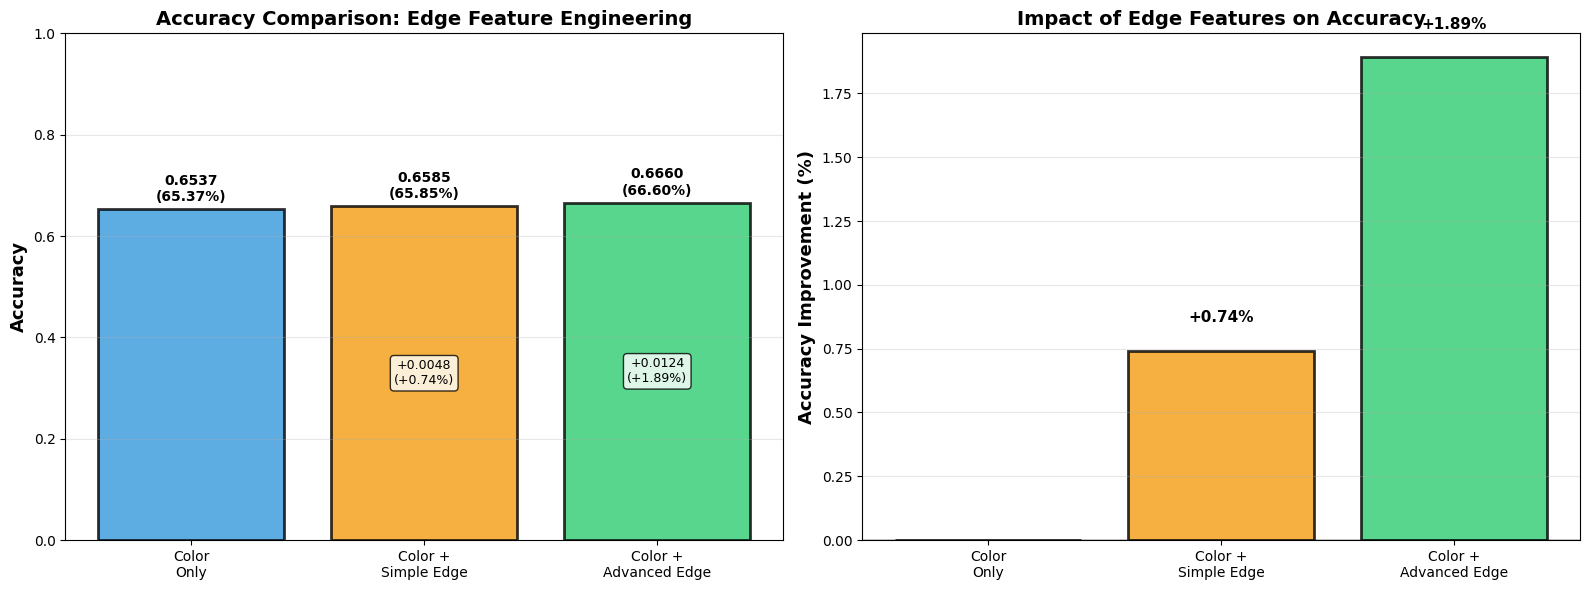

In [50]:
# Visualize all comparisons
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = ['Color\nOnly', 'Color +\nSimple Edge', 'Color +\nAdvanced Edge']
accuracies = [color_acc, simple_acc, advanced_acc]
colors = ['#3498db', '#f39c12', '#2ecc71']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Accuracy Comparison: Edge Feature Engineering', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels and improvement
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}\n({height*100:.2f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    if i > 0:
        improvement = acc - color_acc
        improvement_pct = (improvement / color_acc) * 100
        axes[0].text(bar.get_x() + bar.get_width()/2., height/2,
                    f'+{improvement:.4f}\n({improvement_pct:+.2f}%)',
                    ha='center', va='center', fontsize=9, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Improvement bars
improvements = [0, simple_improvement, advanced_improvement]
improvement_pcts = [0, (simple_improvement/color_acc)*100, (advanced_improvement/color_acc)*100]

bars2 = axes[1].bar(models, improvement_pcts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy Improvement (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Impact of Edge Features on Accuracy', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, pct in zip(bars2, improvement_pcts):
    height = bar.get_height()
    if height != 0:
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{pct:+.2f}%',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'advanced_edge_comparison.png', dpi=150, bbox_inches='tight')
plt.show()